## SageMaker - Tensorflow, Keras, Docker, Local - Using Script Mode

#### Before we start. make Sure you have - 

#### Install AWS CMD Line -> https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html

#### Run Below in PowerShell

`aws configure`

You will be asked to provide below. You can find these in you AWS Security Credential

`AWS Access Key ID [None]:` 

`AWS Secret Access Key [None]:`

`Default region name [None]:` 

`Default output format [None]: text`

After this you are all set to use AWS CMD.

#### Install Docker -> https://docs.docker.com/desktop/windows/install/

#### Install Anaconda -> https://www.anaconda.com/

`conda create -n localsm python==3.7`

`conda activate localsm`

`conda install pip pandas tensorflow==1.15 keras`

`pip install sagemaker`

`conda install ipykernel`

`python -m ipykernel install --username --name localsm --display-name "Python (localsm)"`

`jupyter notebook&`

`Make sure docker is running`


In [1]:
!pip install boto3 
!pip install sagemaker
!pip install tensorflow keras

In [2]:
!pip install sagemaker[local]

In [3]:
!pip install matplotlib

In [4]:
import tensorflow
import boto3
import sagemaker
import keras
import os
import numpy as np
from keras.datasets import fashion_mnist

print(tensorflow.__version__)
print(keras.__version__)
print(sagemaker.__version__)

2.8.0
2.8.0
2.59.0


If you want to keep everything local, and not use Amazon S3 either, you can enable “local_code”. This is just an experimental thing so not fully integrated.

In [5]:
from sagemaker.local import LocalSession
sess = LocalSession()
sess.config = {'local': {'local_code': True}}

Windows Support for Local Mode is Experimental


The below will create a session for S3 and Use the AWS region configured with the AWS CLI.

In [6]:
# sess = sagemaker.Session()  
# sess = sagemaker.Session(boto3.session.Session(region_name='eu-west-1'))

This doesn't work on your local machine because it doesn't have an IAM role :)

In [7]:
# role = sagemaker.get_execution_role()

This is the SageMaker role you're already using, it will work just fine. If you have AWS account you can get this from SageMaker Control Panel. Or if you have AWS CMD set up run: `aws iam list-roles|findstr SageMaker-Execution`. This will give you the arn.

In [8]:
role = 'ADD URL IAM ROLE'

Load the Data and save it on your local directory. We can use S3 also but we will keep everything local.

In [9]:
(x_train, y_train), (x_val, y_val) = fashion_mnist.load_data()

os.makedirs("./data", exist_ok = True)

np.savez('./data/training', image=x_train, label=y_train)
np.savez('./data/validation', image=x_val, label=y_val)

Define the path from where we will read the data. And the output_path where we will save the local copy of the model. 

In [14]:
# Train on local data. S3 URIs would work too.
training_input_path   = 'file://data/training.npz'
validation_input_path = 'file://data/validation.npz'

# Store model locally. A S3 URI would work too.
output_path           = 'file://C:/Users/sahug/Documents/GitHub/sagemaker/model'

Now create **Tensorflow Estimator**. 
Handle end-to-end Amazon SageMaker training and deployment tasks.Subclasses must define a way to determine what image to use for training, what hyperparameters to use, and how to create an appropriate predictor instance.

Couple of important points- 

**1. `entry_point: mnist_keras_tf20_compat.py`** - Here we are using an already trained model. In reality we will build and train this model for our purpose and then we will use the processes we see here to create the image and deploy it to SageMaker.

**2. `instance_type: local`** - As we will be building it in our local and then deploy.

**3. `hyperparameters: {'epochs': 1}`** - We are passing the hyperparameter to our original model `mnist_keras_tf20_compat.py`. You can check the original model. `mnist_keras_tf20_compat.py`

**4. `output_path: output_path`** - We are passing our output_path to save a copy locally. Also SageMaker will save it at `/opt/ml/shared/model`

In [15]:
from sagemaker.tensorflow import TensorFlow

tf_estimator = TensorFlow(entry_point='mnist_keras_tf20_compat.py',
                          role=role,
                          instance_count=1, 
                          instance_type='local',   # Train on the local CPU ('local_gpu' if it has a GPU)
                          framework_version='2.0', 
                          py_version='py3',
                          hyperparameters={'epochs': 1},
                          output_path=output_path
                         )

Windows Support for Local Mode is Experimental


**Fit**

When a model is fit using SageMaker, the process is as follows.

- A compute instance (a server somewhere) is started up with the properties that we specified.
- When the compute instance is ready, the code, in the form of a container, that is used to fit the model is loaded and executed.
- When this code is executed, it is provided access to the training (and possibly validation) data stored on S3.
- Once the compute instance has finished fitting the model, the resulting model artifacts are stored on S3 and the compute instance is shut down.


This will pull (once) the SageMaker CPU/GPU container for TensorFlow to your local machine. Make sure that Docker is running and that docker-compose is installed

In [16]:
tf_estimator.fit({'training': training_input_path, 'validation': validation_input_path})

Creating wopg5yssfl-algo-1-i871o ... 
Creating wopg5yssfl-algo-1-i871o ... done
Attaching to wopg5yssfl-algo-1-i871o
wopg5yssfl-algo-1-i871o | 2022-05-03 03:54:17,975 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
wopg5yssfl-algo-1-i871o | 2022-05-03 03:54:17,986 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
wopg5yssfl-algo-1-i871o | 2022-05-03 03:54:18,031 botocore.credentials INFO     Found credentials in environment variables.
wopg5yssfl-algo-1-i871o | 2022-05-03 03:54:18,403 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
wopg5yssfl-algo-1-i871o | 2022-05-03 03:54:18,432 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
wopg5yssfl-algo-1-i871o | 2022-05-03 03:54:18,462 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
wopg5yssfl-algo-1-i871o | 2022-05-03 03:54:18,486 sagemaker-training-toolkit INFO 

wopg5yssfl-algo-1-i871o | Collecting keras-metrics
wopg5yssfl-algo-1-i871o |   Downloading keras_metrics-1.1.0-py2.py3-none-any.whl (5.6 kB)
wopg5yssfl-algo-1-i871o | Requirement already satisfied: Keras>=2.1.5 in /usr/local/lib/python3.6/site-packages (from keras-metrics) (2.3.1)
wopg5yssfl-algo-1-i871o | Requirement already satisfied: scipy>=0.14 in /usr/local/lib/python3.6/site-packages (from Keras>=2.1.5->keras-metrics) (1.2.2)
wopg5yssfl-algo-1-i871o | Requirement already satisfied: six>=1.9.0 in /usr/local/lib/python3.6/site-packages (from Keras>=2.1.5->keras-metrics) (1.15.0)
wopg5yssfl-algo-1-i871o | Requirement already satisfied: keras-preprocessing>=1.0.5 in /usr/local/lib/python3.6/site-packages (from Keras>=2.1.5->keras-metrics) (1.1.0)
wopg5yssfl-algo-1-i871o | Requirement already satisfied: keras-applications>=1.0.6 in /usr/local/lib/python3.6/site-packages (from Keras>=2.1.5->keras-metrics) (1.0.8)
wopg5yssfl-algo-1-i871o | Requirement already satisfied: numpy>=1.9.1 in 

wopg5yssfl-algo-1-i871o exited with code 0
Aborting on container exit...
===== Job Complete =====


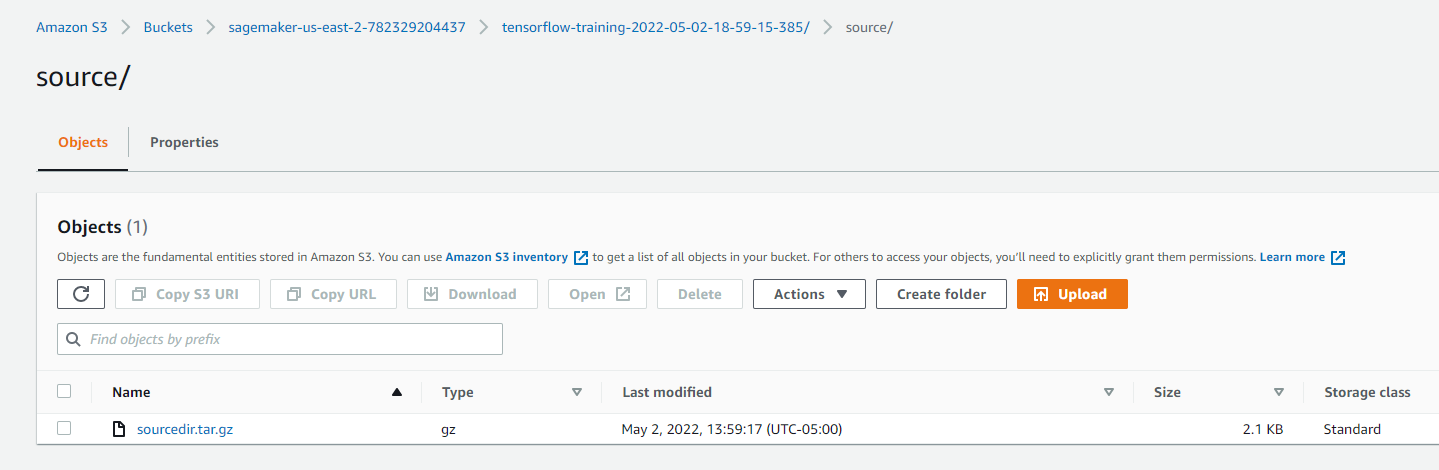

Check the image in your local docker.

In [17]:
!docker images | findstr tensorflow

763104351884.dkr.ecr.us-east-2.amazonaws.com/tensorflow-training   2.0-cpu-py3   a19ddacd606a   14 months ago   1.97GB


#### We can see this in our Docker.

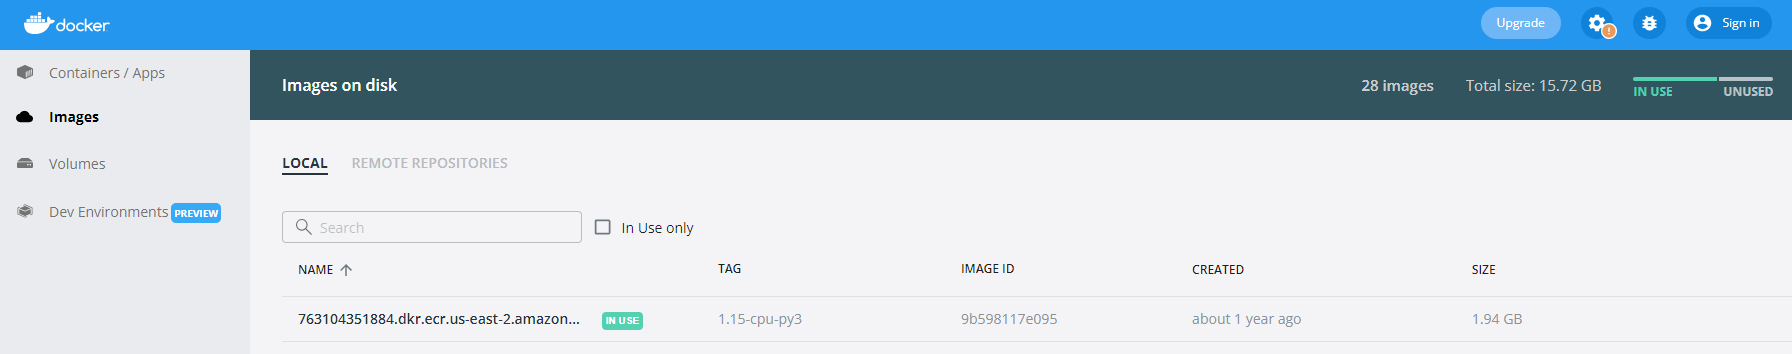

**Deploy**
It starts with putting your tarballed ML models into an AWS S3 bucket. Then you deploy your Docker image to AWS ECR, which will be consumed by your SageMaker. Docker is used to package your ML inference logic code into a containerized environment. SageMaker will also consume your models in S3 as well. As a client, you only interact with the SageMaker endpoint, which downloads your models from S3 first and invokes your ML inference code from ECR. 

**Note**: No endpoint is created for local instance.

Deploys the estimator to an Endpoint and optionally returns a Predictor. 

In [18]:
import time

tf_predictor = tf_estimator.deploy(initial_instance_count=1, instance_type='local')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Attaching to pkhni7xxg6-algo-1-8guvj
pkhni7xxg6-algo-1-8guvj | INFO:__main__:starting services
pkhni7xxg6-algo-1-8guvj | INFO:tfs_utils:using default model name: model
pkhni7xxg6-algo-1-8guvj | INFO:tfs_utils:tensorflow serving model config: 
pkhni7xxg6-algo-1-8guvj | model_config_list: {
pkhni7xxg6-algo-1-8guvj |   config: {
pkhni7xxg6-algo-1-8guvj |     name: "model",
pkhni7xxg6-algo-1-8guvj |     base_path: "/opt/ml/model/model",
pkhni7xxg6-algo-1-8guvj |     model_platform: "tensorflow"
pkhni7xxg6-algo-1-8guvj |   }
pkhni7xxg6-algo-1-8guvj | }
pkhni7xxg6-algo-1-8guvj | 
pkhni7xxg6-algo-1-8guvj | 
pkhni7xxg6-algo-1-8guvj | INFO:__main__:using default model name: model
pkhni7xxg6-algo-1-8guvj | INFO:__main__:tensorflow serving model config: 
pkhni7xxg6-algo-1-8guvj | model_config_list: {
pkhni7xxg6-algo-1-8guvj |   config: {
pkhni7xxg6-algo-1-8guvj |     name: "model",
pkhni7xxg6-algo-1-8guvj |     base_path: "/opt/ml/model/model",
pkhni7xxg6-algo-1-8guvj |     model_platform: "tenso

pkhni7xxg6-algo-1-8guvj | 2022-05-03 03:58:54.334414: I tensorflow_serving/util/retrier.cc:46] Retrying of Reserving resources for servable: {name: model version: 1} exhausted max_num_retries: 0
pkhni7xxg6-algo-1-8guvj | 2022-05-03 03:58:54.334510: I tensorflow_serving/core/basic_manager.cc:739] Successfully reserved resources to load servable {name: model version: 1}
pkhni7xxg6-algo-1-8guvj | 2022-05-03 03:58:54.334562: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: model version: 1}
pkhni7xxg6-algo-1-8guvj | 2022-05-03 03:58:54.334615: I tensorflow_serving/core/loader_harness.cc:74] Loading servable version {name: model version: 1}
pkhni7xxg6-algo-1-8guvj | 2022-05-03 03:58:54.337161: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:31] Reading SavedModel from: /opt/ml/model/model/1
pkhni7xxg6-algo-1-8guvj | 2022-05-03 03:58:54.381699: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:54] Reading meta graph with tag

**Make Predictions**

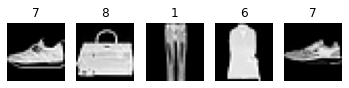

In [19]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

num_samples = 5
indices = random.sample(range(x_val.shape[0] - 1), num_samples)
images = x_val[indices]/255
labels = y_val[indices]

for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')

prediction = tf_predictor.predict(images.reshape(num_samples, 1, 28, 28))
prediction = np.array(prediction)
predicted_label = prediction.argmax(axis=0)
print('Predicted labels are: {}'.format(predicted_label))